In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import torch as t
from utils.config import opt
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
import numpy as np
import pickle

%matplotlib inline

TRAIN_MODE = False

In [2]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

# Load model trained with caffe pretrained model

In [3]:
trainer.load('./checkpoints/fasterrcnn_02272314_0.6720744290992889')
opt.caffe_pretrain=True # this model was trained from caffe-pretrained model

In [4]:
img = read_image('misc/demo.jpg')
img = t.from_numpy(img)[None]

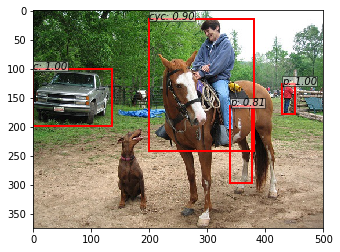

In [5]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)

vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

# Display a Kitti image

In [6]:
import os

dataset_dir = '/media/tadenoud/DATADisk/datasets/kitti_2d'  # School comp
# dataset_dir = '/home/tadenoud/Documents/kitti' # Laptop

img_paths = [
    os.path.join(dataset_dir, 'training/image_2/005009.png'),
    os.path.join(dataset_dir, 'training/image_2/005010.png')
]

imgs = np.array([read_image(p) for p in img_paths])

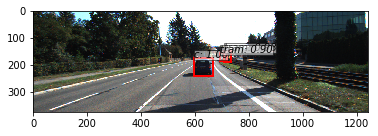

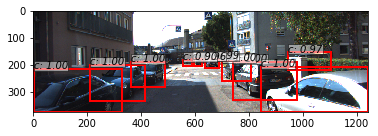

In [7]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(imgs,visualize=True)
vis_bbox(at.tonumpy(imgs[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

vis_bbox(at.tonumpy(imgs[1]),
         at.tonumpy(_bboxes[1]),
         at.tonumpy(_labels[1]).reshape(-1),
         at.tonumpy(_scores[1]).reshape(-1))

In [8]:
# Read a Kitti GT label
from data.util import read_bbox

img_label_paths = [
    os.path.join(dataset_dir, 'training/label_2/005009.txt'),
    os.path.join(dataset_dir, 'training/label_2/005010.txt')
]

gt = np.array([read_bbox(p, ignore_dontcare=True) for p in img_label_paths]) 
gt_bboxes = gt[:,0]
gt_labels = gt[:,1]

scales = np.array([[im.shape[2] / im.shape[1]] for im in imgs])

print(scales)

[[3.312]
 [3.312]]


# Train mahalanobis features with entire training dataset

In [9]:
from utils.config import opt
from data.dataset import Dataset, TestDataset
from torch.utils.data import DataLoader

print('load data')

opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
dataset = Dataset(opt)
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

if TRAIN_MODE:
    mahal_means, mahal_cov = trainer.faster_rcnn.train_ood(dataloader)

    with open('kitti_features.pickle', 'wb') as f:
        pickle.dump(trainer.faster_rcnn.features, f)

    with open('mahal_means.pickle', 'wb') as f:
        pickle.dump(mahal_means, f)

    with open('mahal_cov.pickle', 'wb') as f:
        pickle.dump(mahal_cov, f)

    with open('inv_mahal_cov.pickle', 'wb') as f:
        pickle.dump(trainer.faster_rcnn.inv_mahal_cov, f)

else:
    with open('kitti_features.pickle', 'rb') as f:
        trainer.faster_rcnn.features = pickle.load(f)

    with open('mahal_means.pickle', 'rb') as f:
        mahal_means = pickle.load(f)
        trainer.faster_rcnn.mahal_means = mahal_means

    with open('mahal_cov.pickle', 'rb') as f:
        mahal_cov = pickle.load(f)
        trainer.faster_rcnn.mahal_cov = mahal_cov

    with open('inv_mahal_cov.pickle', 'rb') as f:
        inv_mahal_cov = pickle.load(f)
        trainer.faster_rcnn.inv_mahal_cov = inv_mahal_cov

load data


In [10]:
from tqdm import tqdm

if TRAIN_MODE:
    with open('gt_labels.pickle', 'wb') as f:
        pickle.dump(trainer.faster_rcnn.gt_labels, f)
# else:
    
with open('gt_labels.pickle', 'rb') as f:
    gt_labels = pickle.load(f)

In [11]:
VOC_BBOX_LABEL_NAMES = (
    'car',
    'van',
    'truck',
    'tram',
    'person',
    'person_sitting',
    'cyclist',
    'misc'
    # 'dontcare
)

for j in range(8):
    print(VOC_BBOX_LABEL_NAMES[j], "count:", sum([i == j for i in gt_labels]))

car count: 2114
van count: 129
truck count: 156
tram count: 24
person count: 357
person_sitting count: 0
cyclist count: 68
misc count: 28


# Visualize features using t-SNE

In [12]:
from time import time
from sklearn.manifold import TSNE

if TRAIN_MODE:
    print("Computing t-SNE embedding")
    tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=20)
    t0 = time()
    X_tsne = tsne.fit_transform(trainer.faster_rcnn.features)
    t1 = time()
    
    with open("tsne_features.pickle", "wb") as f:
        pickle.dump(X_tsne, f)

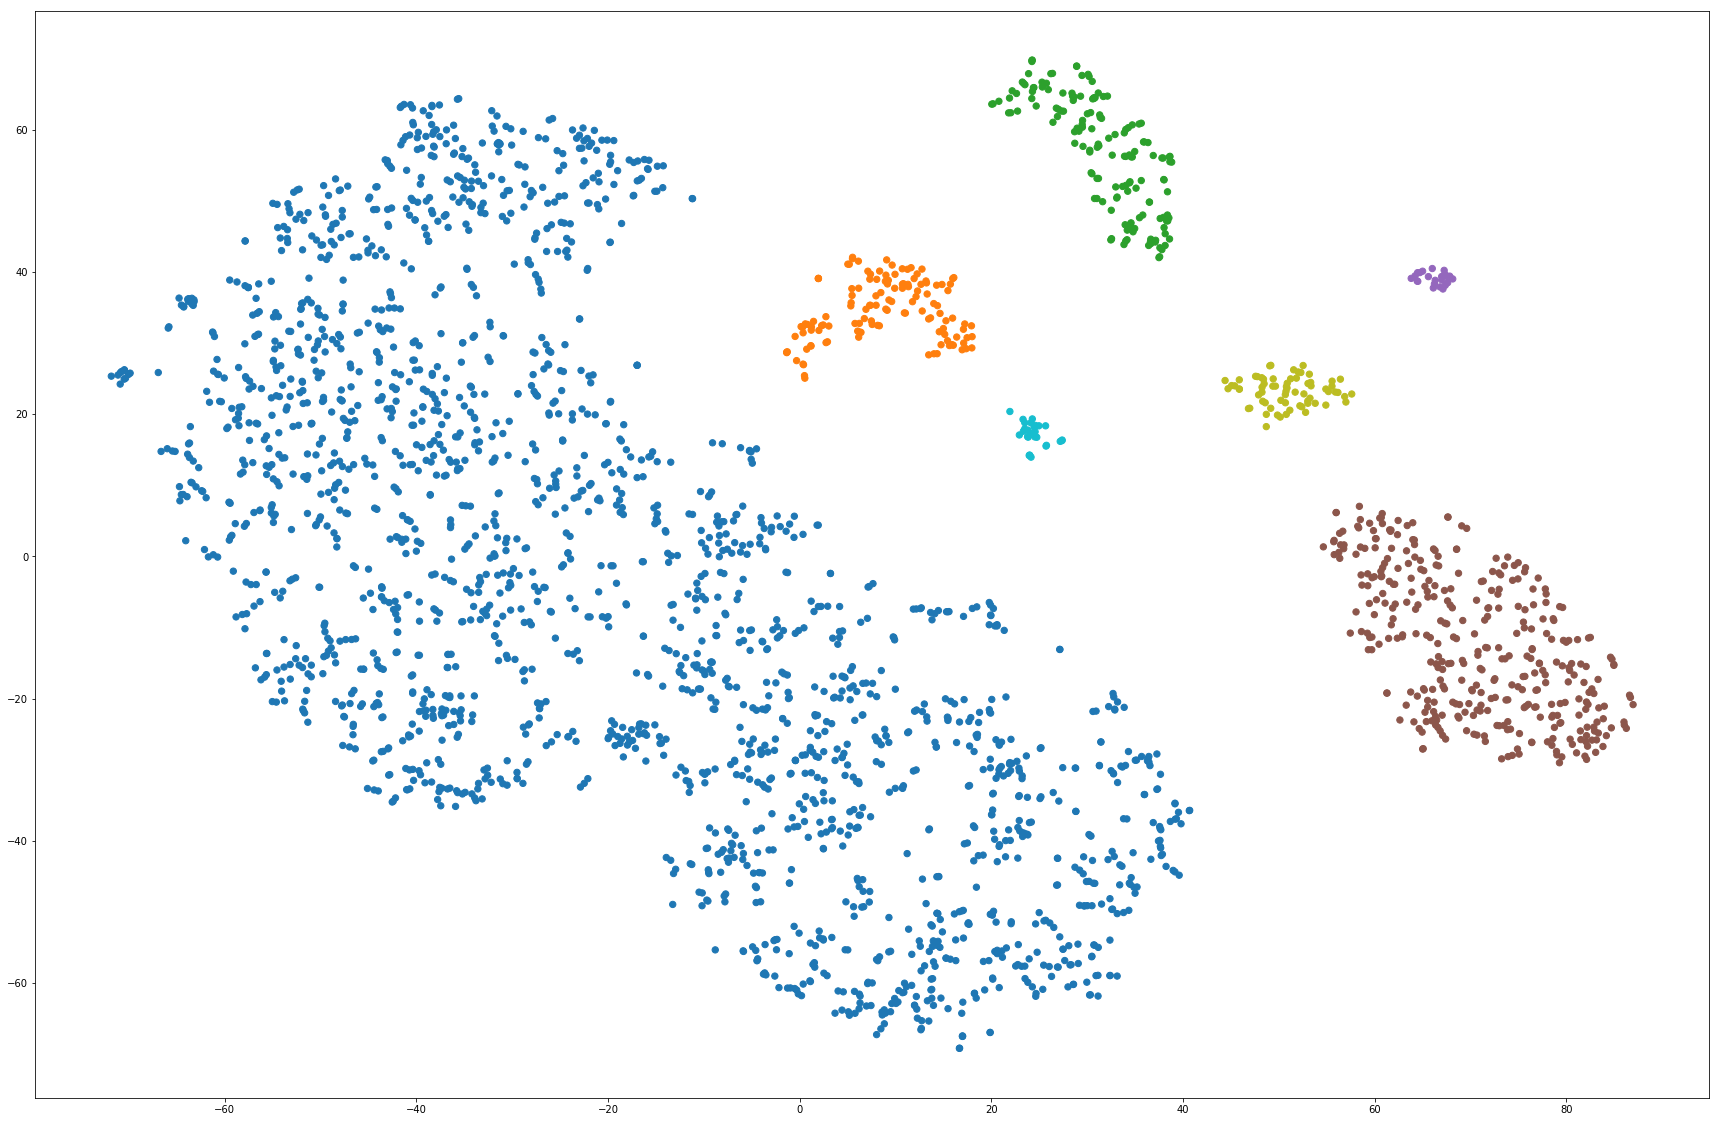

In [13]:
import matplotlib.pyplot as plt

with open("tsne_features.pickle", "rb") as f:
    X_tsne = pickle.load(f)

mask = (gt_labels != -1)
plt.figure(figsize=(30, 20))
plt.scatter(X_tsne[:,0][mask], X_tsne[:,1][mask], c=gt_labels[mask], s=40, cmap=plt.cm.get_cmap('tab10'))
plt.show()

# Predict class using features

In [14]:
# Evaluate baseline softmax method
from train import eval, eval_mahal

print('load data') 
test_dataset = TestDataset(opt)
test_dataloader = DataLoader(test_dataset,
                             batch_size=1,
                             shuffle=False,
                             pin_memory=True,
                             num_workers=opt.num_workers)

if TRAIN_MODE:
    baseline_result = eval(test_dataloader, trainer.faster_rcnn, test_num=3768)
    with open("baseline_results.pickle", 'wb') as f:
        pickle.dump(baseline_result, f)
    
with open("baseline_results.pickle", 'rb') as f:
    baseline_result = pickle.load(f)
    
print(baseline_result)

load data
{'map': 0.6720744290992889, 'ap': array([0.80918346, 0.79683744, 0.90151216, 0.90841999, 0.60692941,
       0.65809045, 0.69562252, 0.        ])}


In [15]:
# Evaluate mahalanobis distance method

if TRAIN_MODE:
    mahal_result = eval_mahal(test_dataloader, trainer.faster_rcnn, test_num=3768)
    with open("mahal_result.pickle", "wb") as f:
        pickle.dump(mahal_result, f)
else:    
    with open("mahal_result.pickle", "rb") as f:
        mahal_result = pickle.load(f)
    
print(mahal_result)



{'map': 0.6118094437829021, 'ap': array([0.78829942, 0.74894812, 0.87868866, 0.90144524, 0.59395682,
       0.29694873, 0.68618856, 0.        ])}


[[100.744415   0.       199.26929  135.90881 ]
 [126.571594 428.38562  177.3793   450.703   ]
 [164.05522  339.46317  297.46326  376.858   ]
 [ 14.93026  199.69063  242.47684  380.8222  ]]
[0 4 4 6]
[ 66.38184   17.668552 155.70113  181.88992 ]


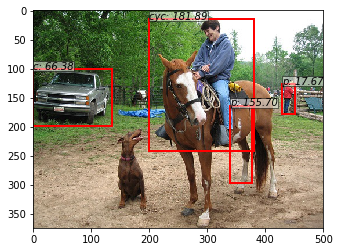

In [16]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis(img,visualize=True)

print(_bboxes[0])
print(_labels[0])
print(_scores[0])

vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0].reshape(-1)),
         at.tonumpy(_scores[0].reshape(-1)))

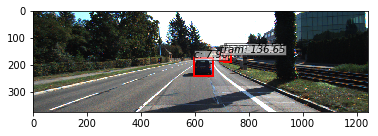

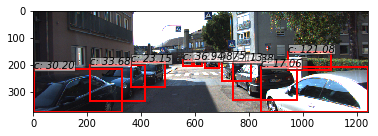

In [17]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis(imgs,visualize=True)
vis_bbox(at.tonumpy(imgs[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

vis_bbox(at.tonumpy(imgs[1]),
         at.tonumpy(_bboxes[1]),
         at.tonumpy(_labels[1]).reshape(-1),
         at.tonumpy(_scores[1]).reshape(-1))

# Do some predictions of "weird car" images from Google

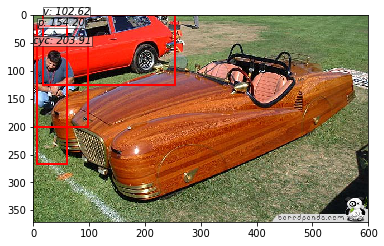

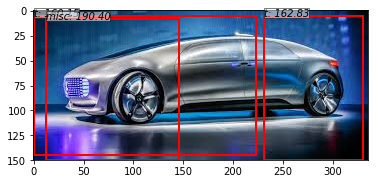

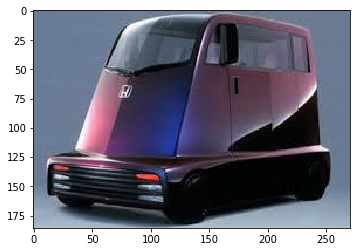

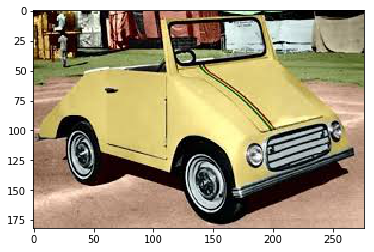

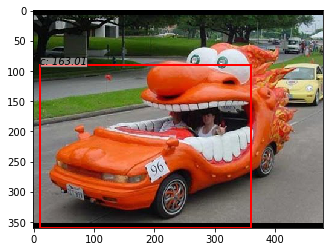

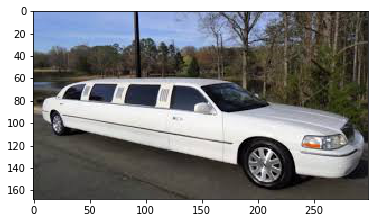

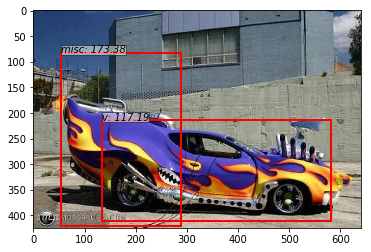

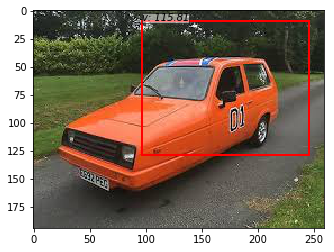

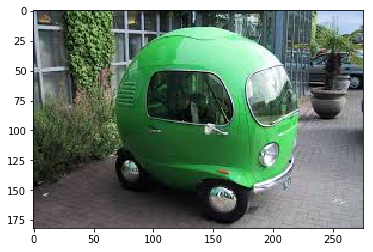

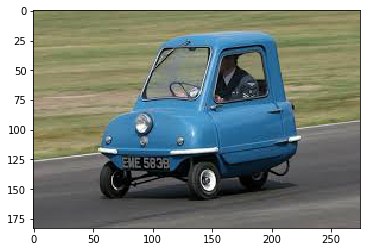

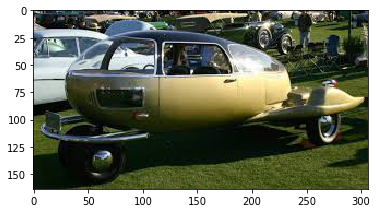

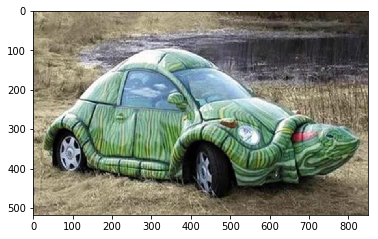

In [18]:
for img_name in os.listdir("./weird_cars"):
    img_path = os.path.join("./weird_cars", img_name)
    im = np.array(read_image(img_path))
    
    _bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis([im], visualize=True)
    
    vis_bbox(at.tonumpy(im),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

# AUROC Mahalanobis on test data

In [19]:
opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
dataset = TestDataset(opt)
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

In [60]:
if TRAIN_MODE:
    features = []
    gt_labels = []
    num_test = 3768

    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels, gt_difficults = list(), list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_, gt_difficults_) in tqdm(enumerate(dataloader), total=num_test):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict_mahalanobis(imgs, [sizes])
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        gt_difficults += list(gt_difficults_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        
    with open("gt_bboxes_test.pickle", "wb") as f:
        pickle.dump(gt_bboxes, f)
    with open("gt_labels_test.pickle", "wb") as f:
        pickle.dump(gt_labels, f)
    with open("gt_difficults_test.pickle", "wb") as f:
        pickle.dump(gt_difficults, f)

    with open("pred_bboxes_test.pickle", "wb") as f:
        pickle.dump(pred_bboxes, f)
    with open("pred_labels_test.pickle", "wb") as f:
        pickle.dump(pred_labels, f)
    with open("pred_scores_test.pickle", "wb") as f:
        pickle.dump(pred_scores, f)

else:
    with open("gt_bboxes_test.pickle", "rb") as f:
        gt_bboxes= pickle.load(f)
    with open("gt_labels_test.pickle", "rb") as f:
        gt_labels = pickle.load(f)
    with open("gt_difficults_test.pickle", "rb") as f:
        gt_difficults = pickle.load(f)

    with open("pred_bboxes_test.pickle", "rb") as f:
        pred_bboxes = pickle.load(f)
    with open("pred_labels_test.pickle", "rb") as f:
        pred_labels = pickle.load(f)
    with open("pred_scores_test.pickle", "rb") as f:
        pred_scores = pickle.load(f)

In [61]:
from model.utils.bbox_tools import bbox_iou

# Ground truth bboxes
print("Ground truth bboxes:", len(np.concatenate(gt_bboxes)))

# Pred bboxes
print("Pred bboxes:", len(np.concatenate(pred_bboxes)))


# Loop through results by image
overlapping_bboxes = list()
correct_classification = list()

def iou(bbox, label, gt_boxes, gt_labels, iou_thresh=0.5):
    for gt_b, gt_l in zip(gt_boxes, gt_labels):
        iou = bbox_iou(np.array([bbox]), np.array([gt_b]))
        if iou >= iou_thresh:
            return True, gt_l == label
    
    return False, False
            

for ii, (gt_bbox, gt_label, pred_bbox, pred_label, pred_score) \
            in enumerate(zip(gt_bboxes, gt_labels, pred_bboxes, pred_labels, pred_scores)):
    # Calculate if the pred bbox has an overlapping gt_bbox
    overlapping_bboxes.append([])
    correct_classification.append([])
    for bbox, label, score in zip(pred_bbox, pred_label, pred_score):
        overlapping_bbox, correct_class = iou(bbox, label, gt_bbox, gt_label, iou_thresh=0.5)
        overlapping_bboxes[-1].append(overlapping_bbox)
        correct_classification[-1].append(correct_class)

Ground truth bboxes: 26766
Pred bboxes: 29545


In [62]:
from itertools import chain
from metrics import barcode_plot, fpr_at_95_tpr, auroc, detection_error

scores = [-1 * s for s in chain(*pred_scores)]
overlap_correct = list(chain(*overlapping_bboxes))
class_correct = list(chain(*correct_classification))
both_correct = [a and b for a, b in zip(overlap_correct, class_correct)]

print("AUROC")
print("Overlap", auroc(scores, overlap_correct))
print("Class", auroc(scores, class_correct))
print("Both", auroc(scores, both_correct))
print()
print("FPR@95TPR")
print("Overlap", fpr_at_95_tpr(scores, overlap_correct))
print("Class", fpr_at_95_tpr(scores, class_correct))
print("Both", fpr_at_95_tpr(scores, both_correct))
print()
print("Detection Err")
print("Overlap", detection_error(scores, overlap_correct))
print("Class", detection_error(scores, class_correct))
print("Both", detection_error(scores, both_correct))

AUROC
Overlap 0.8560008933534278
Class 0.911311584308863
Both 0.911311584308863

FPR@95TPR
Overlap 0.7937717565151943
Class 0.4532584818159629
Both 0.4532584818159629

Detection Err
Overlap 0.4218382994883013
Class 0.25157997696918466
Both 0.25157997696918466


/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


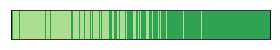

In [63]:
from metrics import barcode_plot, fpr_at_95_tpr, auroc
barcode_plot(scores, prediction_correct)

# AUROC Max Softmax on test data

In [64]:
opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
dataset = TestDataset(opt)
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

In [65]:
if TRAIN_MODE:
    features = []
    gt_labels = []
    num_test = 3768

    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels, gt_difficults = list(), list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_, gt_difficults_) in tqdm(enumerate(dataloader), total=num_test):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs, [sizes])
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        gt_difficults += list(gt_difficults_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        
    with open("gt_bboxes_test_softmax.pickle", "wb") as f:
        pickle.dump(gt_bboxes, f)
    with open("gt_labels_test_softmax.pickle", "wb") as f:
        pickle.dump(gt_labels, f)
    with open("gt_difficults_test_softmax.pickle", "wb") as f:
        pickle.dump(gt_difficults, f)

    with open("pred_bboxes_test_softmax.pickle", "wb") as f:
        pickle.dump(pred_bboxes, f)
    with open("pred_labels_test_softmax.pickle", "wb") as f:
        pickle.dump(pred_labels, f)
    with open("pred_scores_test_softmax.pickle", "wb") as f:
        pickle.dump(pred_scores, f)

else:
    with open("gt_bboxes_test_softmax.pickle", "rb") as f:
        gt_bboxes = pickle.load(f)
    with open("gt_labels_test_softmax.pickle", "rb") as f:
        gt_labels = pickle.load(f)
    with open("gt_difficults_test_softmax.pickle", "rb") as f:
        gt_difficults = pickle.load(f)

    with open("pred_bboxes_test_softmax.pickle", "rb") as f:
        pred_bboxes = pickle.load(f)
    with open("pred_labels_test_softmax.pickle", "rb") as f:
        pred_labels = pickle.load(f)
    with open("pred_scores_test_softmax.pickle", "rb") as f:
        pred_scores = pickle.load(f)

In [66]:
from model.utils.bbox_tools import bbox_iou

# Ground truth bboxes
print("Ground truth bboxes:", len(np.concatenate(gt_bboxes)))

# Pred bboxes
print("Pred bboxes:", len(np.concatenate(pred_bboxes)))


# Loop through results by image
overlapping_bboxes = list()
correct_classification = list()

def iou(bbox, label, gt_boxes, gt_labels, iou_thresh=0.5):
    for gt_b, gt_l in zip(gt_boxes, gt_labels):
        iou = bbox_iou(np.array([bbox]), np.array([gt_b]))
        if iou >= iou_thresh:
            return True, gt_l == label
    
    return False, False
            

for ii, (gt_bbox, gt_label, pred_bbox, pred_label, pred_score) \
            in enumerate(zip(gt_bboxes, gt_labels, pred_bboxes, pred_labels, pred_scores)):
    # Calculate if the pred bbox has an overlapping gt_bbox
    overlapping_bboxes.append([])
    correct_classification.append([])
    for bbox, label, score in zip(pred_bbox, pred_label, pred_score):
        overlapping_bbox, correct_class = iou(bbox, label, gt_bbox, gt_label, iou_thresh=0.5)
        overlapping_bboxes[-1].append(overlapping_bbox)
        correct_classification[-1].append(correct_class)

Ground truth bboxes: 26766
Pred bboxes: 29545


In [67]:
from itertools import chain
from sklearn.metrics import roc_auc_score

scores = list(chain(*pred_scores))
overlap_correct = list(chain(*overlapping_bboxes))
class_correct = list(chain(*correct_classification))
both_correct = [a and b for a, b in zip(overlap_correct, class_correct)]

print("AUROC")
print("Overlap", auroc(scores, overlap_correct))
print("Class", auroc(scores, class_correct))
print("Both", auroc(scores, both_correct))
print()
print("FPR@95TPR")
print("Overlap", fpr_at_95_tpr(scores, overlap_correct))
print("Class", fpr_at_95_tpr(scores, class_correct))
print("Both", fpr_at_95_tpr(scores, both_correct))
print()
print("Detection Err")
print("Overlap", detection_error(scores, overlap_correct))
print("Class", detection_error(scores, class_correct))
print("Both", detection_error(scores, both_correct))

AUROC
Overlap 0.9139383442295833
Class 0.9669314004220345
Both 0.9669314004220345

FPR@95TPR
Overlap 0.6499200301063129
Class 0.174762020990969
Both 0.174762020990969

Detection Err
Overlap 0.3499388689334694
Class 0.11236072534421523
Both 0.11236072534421523


/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


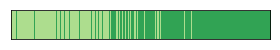

In [68]:
from metrics import barcode_plot
barcode_plot(scores, prediction_correct)